<a href="https://colab.research.google.com/github/PierreCasco/twitter_and_football/blob/master/Twitter_and_Football.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import tweepy
import jsonpickle

In [0]:
CONSUMER_KEY = 'IxR5FXfLLMH88LcBKi3HDxmIg'
CONSUMER_SECRET = '2UkT3BC4b1bdzJvgYqPltWSDtFBMxbwfmD4AfDnTMumrOP3Hqn'
OAUTH_TOKEN = '323252972-qtFGigmi7hxyU5rPgCSoSUjPbNYi3rVog65UqRFy'
OAUTH_SECRET = 'jlLtJE9NV7FYet4ry5aFMh2fFhfximt6Lyy8MaiU4Sa5p'

In [0]:
def oauth_login():
  # get the authorization from Twitter and save in the Tweepy package
  auth = tweepy.OAuthHandler(CONSUMER_KEY,CONSUMER_SECRET)
  auth.set_access_token(OAUTH_TOKEN,OAUTH_SECRET)
  tweepy_api = tweepy.API(auth)

    # if a null api is returned, give error message
  if (not tweepy_api):
      print ("Problem Connecting to API with OAuth")

  # return the Twitter api object that allows access for the Tweepy api functions
  return tweepy_api

# login to Twitter with extended rate limiting
#  must be used with the Tweepy Cursor to wrap the search and enact the waits
def appauth_login():
  # get the authorization from Twitter and save in the Tweepy package
  auth = tweepy.AppAuthHandler(CONSUMER_KEY,CONSUMER_SECRET)
  # apparently no need to set the other access tokens
  tweepy_api = tweepy.API(auth, wait_on_rate_limit=False, wait_on_rate_limit_notify=True)

  # if a null api is returned, give error message
  if (not tweepy_api):
      print ("Problem Connecting to API with AppAuth")

  # return the Twitter api object that allows access for the Tweepy api functions
  return tweepy_api

In [0]:
if __name__ == '__main__':
  tweepy_api = oauth_login()
  print ("Twitter OAuthorization: ", tweepy_api)
  tweepy_api = appauth_login()
  print ("Twitter AppAuthorization: ", tweepy_api)

Twitter OAuthorization:  <tweepy.api.API object at 0x7f17cb86b630>
Twitter AppAuthorization:  <tweepy.api.API object at 0x7f17e262c198>


In [0]:
def get_save_tweets(filepath, api, query, max_tweets=1000000, lang='en'):

    tweetCount = 0

    #Open file and save tweets
    with open(filepath, 'w') as f:

        # Send the query
        for tweet in tweepy.Cursor(api.search,q=query,lang=lang).items(max_tweets):         

            #Convert to JSON format
            f.write(jsonpickle.encode(tweet._json, unpicklable=False) + '\n')
            tweetCount += 1

        #Display how many tweets we have collected
        print("Downloaded {0} tweets".format(tweetCount)) 

In [0]:
query = '#NFLKickoff OR #ThursdayNightFootball OR #NFL100'

# Get those tweets
get_save_tweets('tweets.json', tweepy_api, query)

In [0]:
def tweets_to_df(path):
    
    tweets = list(open('tweets.json', 'rt'))
    
    text = []
    month = []
    day = []
    hashtag = []
    url = []
    favorite = []
    reply = []
    retweet = []
    follower = []
    following = []
    user = []
    screen_name = []

    for t in tweets:
        t = jsonpickle.decode(t)
        
        # Text
        text.append(t['text'])
        
        # Decompose date
        date = t['created_at']
        month.append(date.split(' ')[1])
        day.append(date.split(' ')[2])
        
        # Has hashtag
        if len(t['entities']['hashtags']) == 0:
            hashtag.append(0)
        else:
            hashtag.append(1)
            
        # Has url
        if len(t['entities']['urls']) == 0:
            url.append(0)
        else:
            url.append(1)
            
        # Number of favs
        favorite.append(t['favorite_count'])
        
        # Is reply?
        if t['in_reply_to_status_id'] == None:
            reply.append(0)
        else:
            reply.append(1)       
        
        # Retweets count
        retweet.append(t['retweet_count'])
        
        # Followers number
        follower.append(t['user']['followers_count'])
        
        # Following number
        following.append(t['user']['friends_count'])
        
        # Add user
        user.append(t['user']['name'])

        # Add screen name
        screen_name.append(t['user']['screen_name'])
        
    d = {'tweet': text,
         'month' : month,
         'day': day,
         'has_hashtag': hashtag,
         'has_url': url,
         'fav_count': favorite,
         'is_reply': reply,
         'retweet_count': retweet,
         'followers': follower,
         'following' : following,
         'user': user,
         'screen_name' : screen_name
        }
    
    return pd.DataFrame(data = d)
        
tweets_df = tweets_to_df('tweets.json')

In [0]:
tweets_df.head(5)

,tweet,month,day,has_hashtag,has_url,fav_count,is_reply,retweet_count,followers,following,user,screen_name
0,RT @SNFonNBC: The FIRST TOUCHDOWN of the NFL's...,Sep,06,1,0,0,0,215,498,580,Emanuel Amador ✭,emanuelswagador
1,RT @NFL: HALFTIME:\n\n#GoPackGo 7\n#Bears100 3...,Sep,06,1,0,0,0,135,290,39,NFL 4 Life,NFL4Life2020
2,RT @NFL: HALFTIME:\n\n#GoPackGo 7\n#Bears100 3...,Sep,06,1,0,0,0,135,768,901,Official.Lyric,LyricSoPretty
3,"@Mr_Sdot_Johnson Yeah, I'm questioning my deci...",Sep,06,1,0,0,1,0,965,1759,#1 Detroit Lions Fan,SwissLionsFan
4,Yeah as I watch this game I don’t think it’s 2...,Sep,06,0,1,0,0,0,5,217,Van Rogers,vronthereal


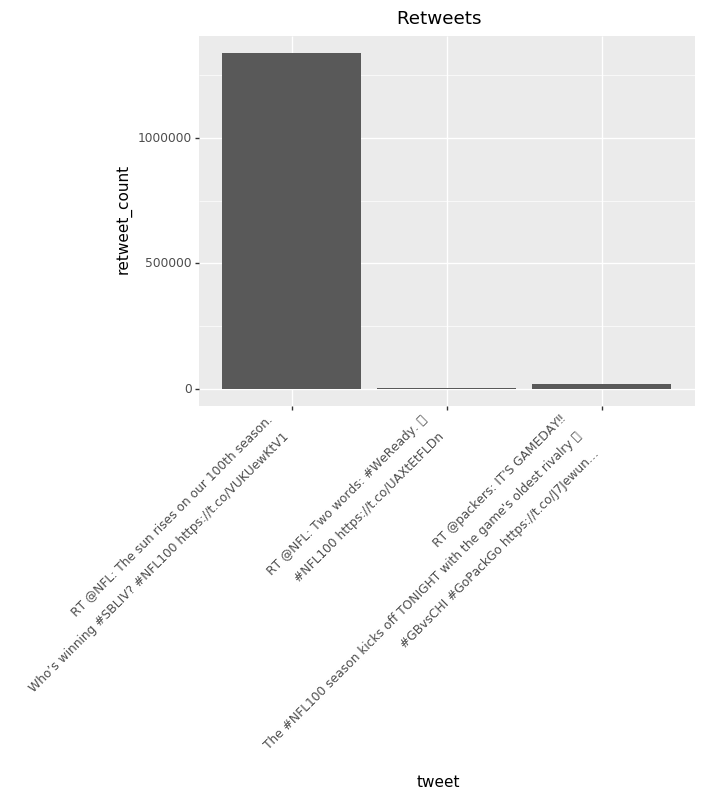

<ggplot: (8733719830206)>

In [0]:
from plotnine import *


#dodge_text = position_dodge(width=0.9)  

(ggplot(tweets_df[tweets_df['retweet_count'] > 1000],
       aes(x='tweet',y='retweet_count')) + 
       geom_col() + theme(axis_text_x=element_text(rotation=45, hjust=1)) + 
      ggtitle('Retweets'))

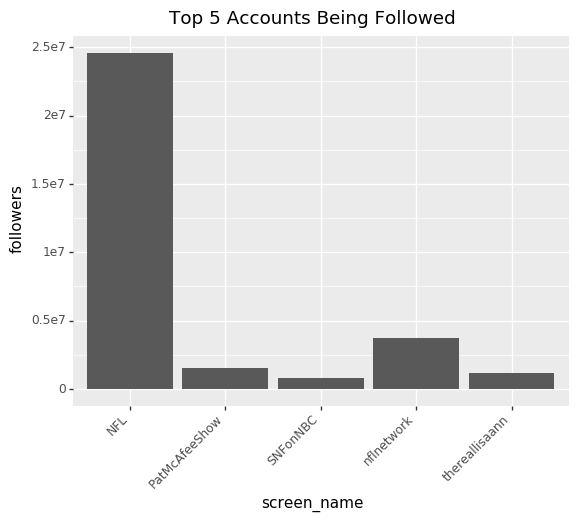

<ggplot: (-9223363303134939725)>

In [0]:
(ggplot(tweets_df.sort_values(by='followers',ascending=False).head(5),
       aes(x='screen_name',y='followers')) + 
       geom_col() + theme(axis_text_x=element_text(rotation=45, hjust=1)) + 
      ggtitle('Top 5 Accounts Being Followed'))

In [4]:
# Connect to state population data
import io
import pandas as pd
import requests

url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2018/national/totals/nst-est2018-alldata.csv"
response = requests.get(url).content
pop = pd.read_csv(io.StringIO(response.decode('utf-8')))
pop.set_index('NAME', inplace=True)
pop.drop(['United States', 'Northeast Region', 'Midwest Region', 'South Region', 'West Region', 'Puerto Rico'], inplace=True, axis=0)
wi_pop = pop['POPESTIMATE2018']['Wisconsin']
il_pop = pop['POPESTIMATE2018']['Illinois']

print("WI pop: ", wi_pop, sep="")
print("IL pop: ", il_pop, sep="")

WI pop: 5813568
IL pop: 12741080
